In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.linear_model import LinearRegression

# Part I

In [52]:
# Import the data
tree = pd.read_csv('tree.csv')
tree

tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)


vert_genes = pd.read_csv('vert_genes.csv')
tree

,Parent,Child,age_ch,t,species
0,222.0,1,0.000000,9.000250,Peromyscus_maniculatus
1,222.0,2,0.000000,9.000250,Mus_musculus
2,221.0,3,0.000000,12.172706,Cricetulus_griseus
3,220.0,4,0.000000,14.684269,Rattus_norvegicus
4,219.0,5,0.000000,17.062881,Mesocricetus_auratus
...,...,...,...,...,...
402,399.0,403,7.861905,1.640772,NaN
403,403.0,404,5.750020,2.111885,NaN
404,404.0,405,5.500000,0.250020,NaN
405,403.0,406,5.000000,2.861905,NaN


In [53]:
sigma_sq = 2500

# Create a directed graph

def create_graph(tree, alpha = 0.4, beta = 1, sigma_sq = 2500):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), time = row["t"], a = alpha*row["t"], b = beta, variance = sigma_sq*row["t"])
            
    return G

G = create_graph(tree)

# # Get the 'b' attribute for a single edge (for example, edge (1, 2))
# b_single_edge = G[222][1]['b']

# print(b_single_edge)

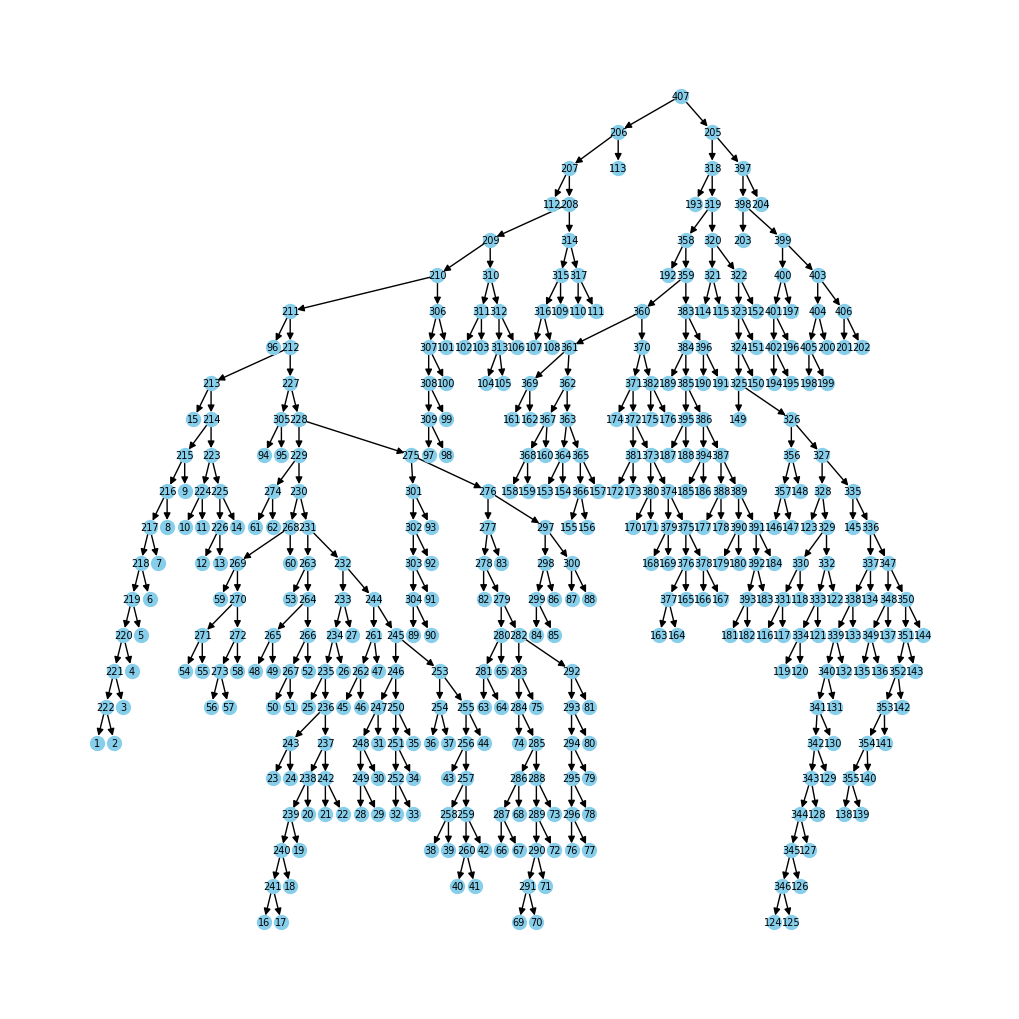

In [54]:
# Plot the graph as a top-down tree
plt.figure(figsize=(10, 10))
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size = 7, node_color = "Skyblue", node_size = 100)
plt.show()

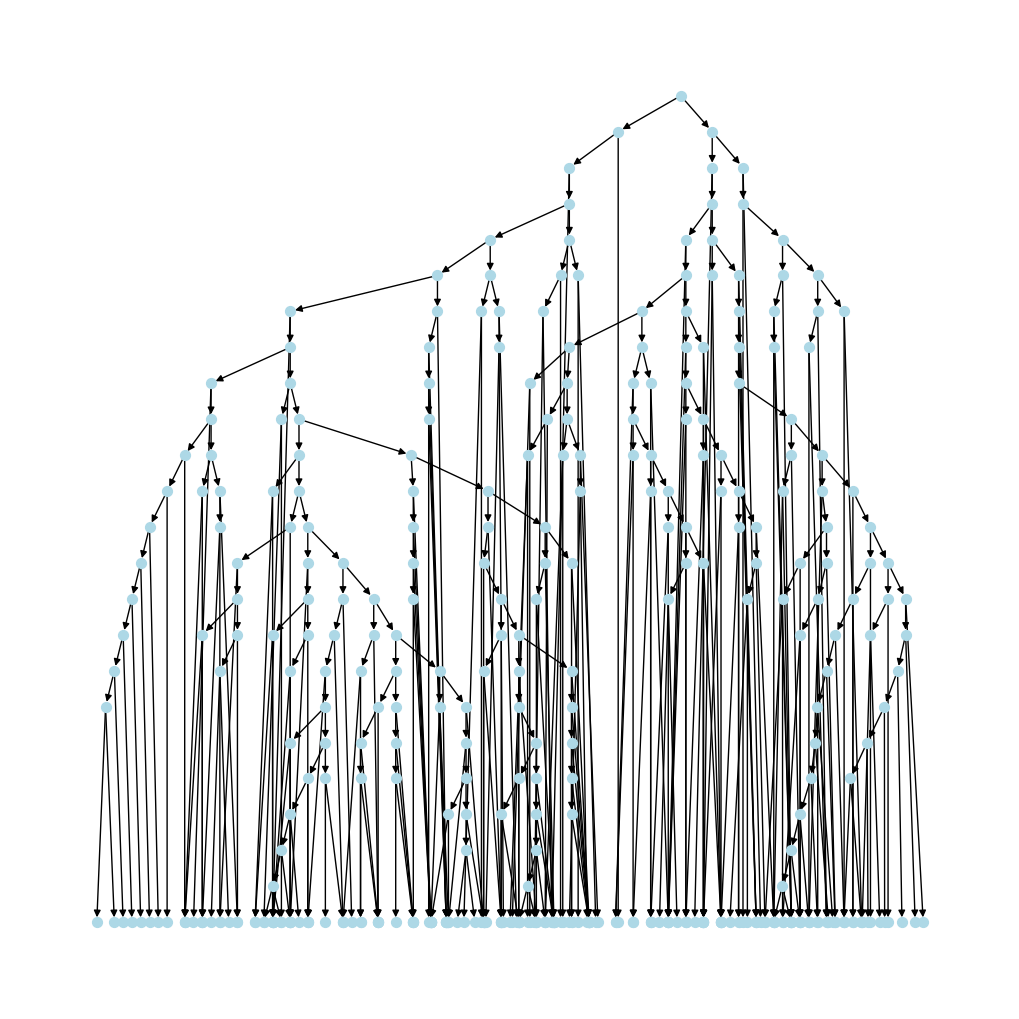

In [55]:
# Get initial layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")


nodes = list(G.nodes)

# Find leaf nodes (nodes with no outgoing edges)
leaves = [node for node in nodes if G.out_degree(node) == 0]

# Find minimum depth of the tree
min_depth = min(pos[node][1] for node in pos)  # Highest Y value

# Adjust leaf positions to be at min_depth
for leaf in leaves:
    pos[leaf] = (pos[leaf][0], min_depth)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=50, node_color="lightblue", edge_color="black")
plt.show()

In [56]:
# Parameters
alpha_0 = 50000
alpha = 0.5
sigma_0_sq = 5000
sigma_sq = 2500
beta = 1

# Simulate length of root node
root = 407

# Function to simulate the length of a node
def simulate_node_length(parent, simulated_lengths):
    for child in G.successors(parent):
        t = G[parent][child]['time']
        mean = alpha * t + beta * simulated_lengths[parent]
        std = np.sqrt(sigma_sq * t)
        simulated_lengths[child] = np.random.normal(mean, std)
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

In [57]:
n = 1000

def simulate_data(n):
    

    X_values = []
    Y_values = []

    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    for i in range(n):
        simulated_lengths = {}
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulated_lengths = simulate_node_length(root, simulated_lengths)

        simulated_x = [simulated_lengths[node] for node in leaf_nodes]
        X_values.append(simulated_x)
        Y_values.append(simulated_lengths[root])

    return(np.array(X_values), np.array(Y_values))

X_values, Y_values = simulate_data(n)

print(X_values.shape)
print(Y_values.shape)

(1000, 204)
(1000,)


In [58]:
print(Y_values[0])

49916.53660225805


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [60]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2)
model.fit(X_train, Y_train)

slope = model.coef_
intercept = model.intercept_

# print(slope)
# print(intercept)

Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2: {r2}")


Mean Absolute Error: 61.59319033985463
Mean Squared Error: 5888.521171649482
Root Mean Squared Error: 76.73670029164326
R^2: -0.061473697524220494


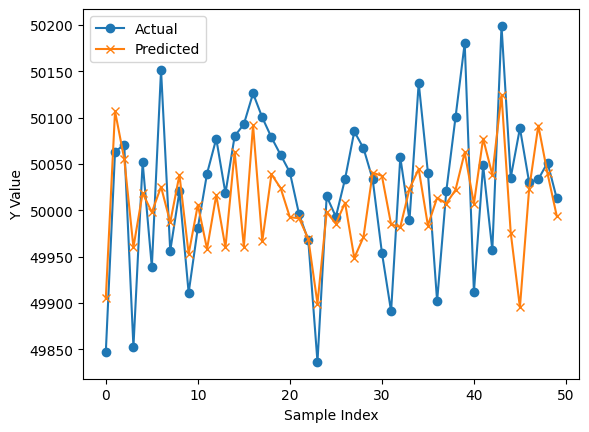

In [61]:
points = 50

plt.plot(Y_test[:points], label="Actual", marker='o')  # First 100 values
plt.plot(Y_pred[:points], label="Predicted", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Y Value")
plt.legend()
plt.show()

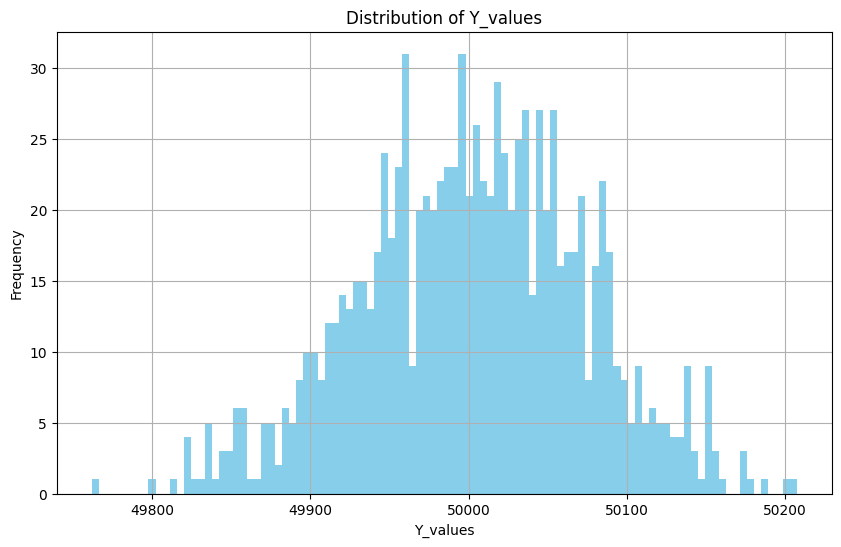

In [62]:
plt.figure(figsize=(10, 6))
plt.hist(Y_values, bins=100, color='skyblue')
plt.title('Distribution of Y_values')
plt.xlabel('Y_values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


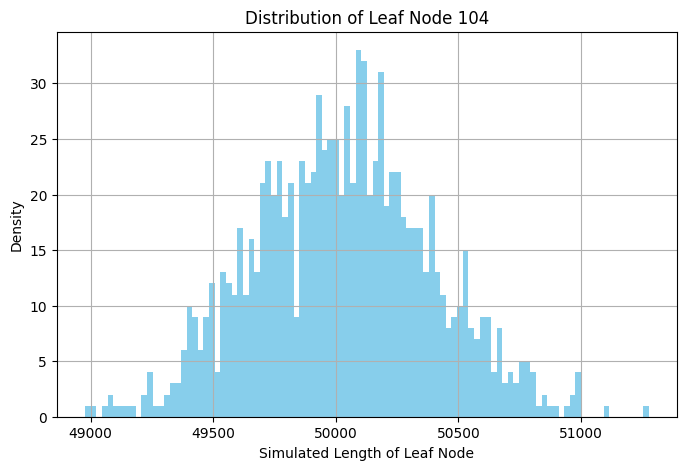

In [63]:
leaf_index = np.random.randint(0,203)  # Choose the index of the leaf node you want to analyze
leaf_data = X_values[:, leaf_index]  # Extract the column for this leaf

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(leaf_data, bins=100, color='skyblue')

# Add labels
plt.xlabel("Simulated Length of Leaf Node")
plt.ylabel("Density")
plt.grid(True)
plt.title(f"Distribution of Leaf Node {leaf_index}")

plt.show()

# Part II

In [64]:
def compute_pair_cliques(graph):
    C = nx.Graph()

    for edge in graph.edges:
        C.add_node(edge)

    return C

clique_tree = compute_pair_cliques(G)

print(clique_tree.number_of_nodes())

406


In [65]:
all_parents = tree["Parent"].unique()

# Find the leaf nodes (parents that do not appear in the 'Child' column)
leaf_nodes = [parent for parent in all_parents if parent not in tree["Child"].values]

In [66]:
def get_first_n_nodes(G, root, n):
    nodes = [root]
    current_level = [root]
    while len(nodes) < n:
        next_level = []
        for node in current_level:
            children = list(G.successors(node))
            next_level.extend(children)
            nodes.extend(children)
            if len(nodes) >= n:
                subgraph = G.subgraph(nodes[:n])
                mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
                return nx.relabel_nodes(subgraph, mapping)
        current_level = next_level
    subgraph = G.subgraph(nodes[:n])
    mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
    return nx.relabel_nodes(subgraph, mapping)

In [67]:
import numpy as np

def compute_gamma(G):
    # Initialize gamma as an identity matrix
    gamma = np.eye(len(G.nodes))

    # Iterate through the nodes
    for node in G.nodes:
        # Get the parent of the node (if exists)
        parent = next(G.predecessors(node), None)
        if parent is None:
            print(f"Node {node} is the root node")
            continue
        
        # Access the edge attribute 'b' for the edge from 'parent' to 'node'
        b = G[parent][node]['b']  # Access the edge (parent -> node) to get 'b'

        gamma[parent-1, node-1] = -b

    return gamma

gamma = compute_gamma(G)

gamma

Node 407 is the root node


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [68]:
def compute_beta():
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a']
        beta[node-1] = G[parent][node]['a']
        
    return beta

def compute_sigma(G):
    sigma = np.zeros((len(G.nodes)))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            # Assign the default value for the root node
            sigma[node - 1] = sigma_0_sq
        else:
            # Access the edge attribute 'variance' only if parent exists
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance
    return sigma

beta = compute_beta()
sigma = compute_sigma(G)


J2 = gamma / sigma

J2

import numpy as np

def compute_J(gamma, sigma):
    # Initialize the sum matrix
    J = np.zeros_like(gamma)
    
    # Iterate over each row in gamma
    for i in range(len(gamma)):
        # Get the i-th row (gamma_i) and the corresponding sigma_i
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Compute the outer product of gamma_i with itself, scaled by 1/sigma_i^2 
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i) # MAYBE USE SIGMA_I^2
        
        # Add the outer product to the sum matrix
        J += outer_product
    
    return J

# Example usage:
J = compute_J(gamma, sigma)

J


array([[0.00017053, 0.00012609, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00012609, 0.00017053, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00019212, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00178928, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00038355,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0002    ]])

In [69]:
# # This J is equal to the J computed in the previous cell

# J = np.sum([np.outer(gamma[i], gamma[i]) / (sigma[i])**2 for i in range(len(G))], axis=0)

# J

In [70]:
# Computing h
h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)

h

array([-2.71050543e-20, -2.71050543e-20,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.71050543e-20,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.71050543e-20,
        0.00000000e+00,  0.00000000e+00,  2.71050543e-20,  2.71050543e-20,
        0.00000000e+00,  0.00000000e+00, -2.71050543e-20,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.71050543e-20,
        2.71050543e-20,  0.00000000e+00,  2.71050543e-20,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [79]:
import numpy as np
import networkx as nx
import pandas as pd

# Define sigma_0_sq for the root node's variance (ensure it's defined)
sigma_0_sq = 2500

# Create a directed graph
def create_graph(tree, alpha=0.4, beta=1, sigma_sq=2500):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), 
                       time=row["t"], a=alpha*row["t"], b=beta, variance=sigma_sq*row["t"])
    return G

# Helper function to get the first n nodes
def get_first_n_nodes(G, root, n):
    nodes = [root]
    current_level = [root]
    while len(nodes) < n:
        next_level = []
        for node in current_level:
            children = list(G.successors(node))
            next_level.extend(children)
            nodes.extend(children)
            if len(nodes) >= n:
                subgraph = G.subgraph(nodes[:n])
                mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
                return nx.relabel_nodes(subgraph, mapping)
        current_level = next_level
    subgraph = G.subgraph(nodes[:n])
    mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
    return nx.relabel_nodes(subgraph, mapping)

# Compute gamma matrix
def compute_gamma(G):
    gamma = np.eye(len(G.nodes))  # Initialize gamma as identity matrix
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        b = G[parent][node]['b']  # Get the edge attribute 'b'
        gamma[parent-1, node-1] = -b  # Assign to gamma (adjust for 0-based indexing)
    return gamma

# Compute beta vector
def compute_beta(G):
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a']
        beta[node-1] = a  # Assign 'a' value to beta (adjust for 0-based indexing)
    return beta

# Compute sigma (variance) vector
def compute_sigma(G):
    sigma = np.zeros(len(G.nodes))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            sigma[node - 1] = sigma_0_sq  # Root node variance (sigma_0_sq)
        else:
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance  # Child node variance
    return sigma

# Compute J matrix
def compute_J(gamma, sigma):
    J = np.zeros_like(gamma)
    for i in range(len(gamma)):
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Ensure no zero variance (avoid division by zero)
        if sigma_i == 0:
            continue
        
        # Compute outer product of gamma_i with itself, scaled by 1/sigma_i^2
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i ** 2)
        J += outer_product
    
    return J

# Message passing function for one iteration (propagate messages)
def message_passing_step(J, h, G):
    # Create a copy of J and h to store the new values
    new_J = np.copy(J)
    new_h = np.copy(h)

    for node in G.nodes:
        parent = next(G.predecessors(node), None)

        if parent is None:
            continue
        
        # Get the necessary attributes for the parent-child relationship
        b = G[parent][node]['b']
        sigma_parent = sigma[parent - 1]  # Parent node's variance
        sigma_node = sigma[node - 1]  # Current node's variance
        
        # Update J and h based on the message passing rules        
        new_J[node-1, parent-1] = -b / sigma_parent
        new_h[node-1] = h[node-1] - (J[node-1, parent-1] * h[parent-1])
    
    return new_J, new_h

# Import the data
tree = pd.read_csv('tree.csv')
tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)
vert_genes = pd.read_csv('vert_genes.csv')

G = create_graph(tree)
gamma = compute_gamma(G)
beta = compute_beta(G)
sigma = compute_sigma(G)
J = compute_J(gamma, sigma)
h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)

# # Perform message passing iterations
# for iteration in range(200):  # Set a reasonable number of iterations
#     J, h = message_passing_step(J, h, G)
#     print(f"Iteration {iteration + 1}:")
#     print("J:", J)
#     print("h:", h)

print(h.shape)


(407,)


In [72]:
tree

,Parent,Child,age_ch,t,species
0,222.0,1,0.000000,9.000250,Peromyscus_maniculatus
1,222.0,2,0.000000,9.000250,Mus_musculus
2,221.0,3,0.000000,12.172706,Cricetulus_griseus
3,220.0,4,0.000000,14.684269,Rattus_norvegicus
4,219.0,5,0.000000,17.062881,Mesocricetus_auratus
...,...,...,...,...,...
402,399.0,403,7.861905,1.640772,NaN
403,403.0,404,5.750020,2.111885,NaN
404,404.0,405,5.500000,0.250020,NaN
405,403.0,406,5.000000,2.861905,NaN


In [76]:
import numpy as np

n = 100000  # Number of simulations

def simulate_node_length(node, simulated_lengths):
    """ Recursively simulate values for all child nodes. """
    for child in G.successors(node):
        # parent_length = simulated_lengths[node]  # Get the parent's simulated value
        # t = G[node][child]['time']  # Time from parent to child
        # mean = alpha * t + beta * simulated_lengths[node] # Mean value for the child node
        a = G[node][child]['a']
        variance = G[node][child]['variance']
        
        # Simulate child node value
        simulated_lengths[child] = np.random.normal(a * simulated_lengths[node], np.sqrt(variance))
        
        # Recursively simulate for its children
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

def simulate_data(n):
    X_values = []
    Y_values = []
    
    all_nodes = list(G.nodes)  # Get all nodes in the graph

    for _ in range(n):
        simulated_lengths = {}
        
        # Simulate root node first
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        
        # Simulate all other nodes recursively
        simulated_lengths = simulate_node_length(root, simulated_lengths)
        
        # Store all node values in order
        X_values.append([simulated_lengths[node] for node in all_nodes])
        Y_values.append(simulated_lengths[root])  # Root node as target
    
    return np.array(X_values), np.array(Y_values)

# Run simulation
X_values, Y_values = simulate_data(n)

# Print shapes to verify
print(X_values.shape)  # Should be (1000, total number of nodes)
print(Y_values.shape)  # Should be (1000,)


(100000, 407)
(100000,)


In [78]:
covariance = np.cov(X_values, rowvar=False)
J_estimate = np.linalg.inv(covariance)

print(covariance)

[[6.00518213e+04 2.16285147e+05 2.16198339e+05 ... 2.04555330e+02
  4.02325164e+03 2.58169475e+03]
 [2.16285147e+05 8.01522600e+05 7.78629358e+05 ... 8.45182388e+02
  1.50054974e+04 9.66608482e+03]
 [2.16198339e+05 7.78629358e+05 8.00871203e+05 ... 7.66455276e+02
  1.43359455e+04 9.17416676e+03]
 ...
 [2.04555330e+02 8.45182388e+02 7.66455276e+02 ... 1.25268011e+04
  2.06789042e+04 1.35813135e+04]
 [4.02325164e+03 1.50054974e+04 1.43359455e+04 ... 2.06789042e+04
  3.50280216e+05 2.29927812e+05]
 [2.58169475e+03 9.66608482e+03 9.17416676e+03 ... 1.35813135e+04
  2.29927812e+05 1.55039000e+05]]


In [110]:
# Compute the conditional distribution of Z_0,...Z_n given X_0,...X_n

def compute_conditional_distribution(y, J, h, n):

    J_xx = J[:n, :n]
    J_xz = J[:n, n:]
    J_zx = J[n:, :n]
    J_zz = J[n:, n:]

    # print(J_xx.shape)
    # print(J_xz.shape)
    # print(J_zx.shape)
    # print(J_zz.shape)

    h_x = h[:n]
    h_z = h[n:]

    print(h_z.shape) # Shape 203
    print(J_xz.shape) # Shape 204, 203

    new_h = h_z - J_zx @ y

    print(new_h.shape) # Shape 203

    return J_zz



y = np.ones(204)
compute_conditional_distribution(y,J,h, 204)

(203,)
(204, 203)
(203,)


array([[ 0.00047522,  0.0002    ,  0.        , ...,  0.        ,
         0.        , -0.0002    ],
       [ 0.0002    ,  0.00030287, -0.00010287, ...,  0.        ,
         0.        , -0.0002    ],
       [ 0.        , -0.00010287,  0.00028556, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.00178928,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00038355,  0.        ],
       [-0.0002    , -0.0002    ,  0.        , ...,  0.        ,
         0.        ,  0.0002    ]])